## Plotting Waveform

In [1]:
import librosa

In [2]:
array, sampling_rate = librosa.load(librosa.ex("trumpet"))

In [3]:
array

array([-1.40682457e-03, -4.46077698e-04, -4.10981564e-04, ...,
        7.96230779e-06, -3.04169989e-05,  1.27650665e-05], dtype=float32)

In [4]:
sampling_rate

22050

In [3]:
import matplotlib.pyplot as plt
import librosa.display

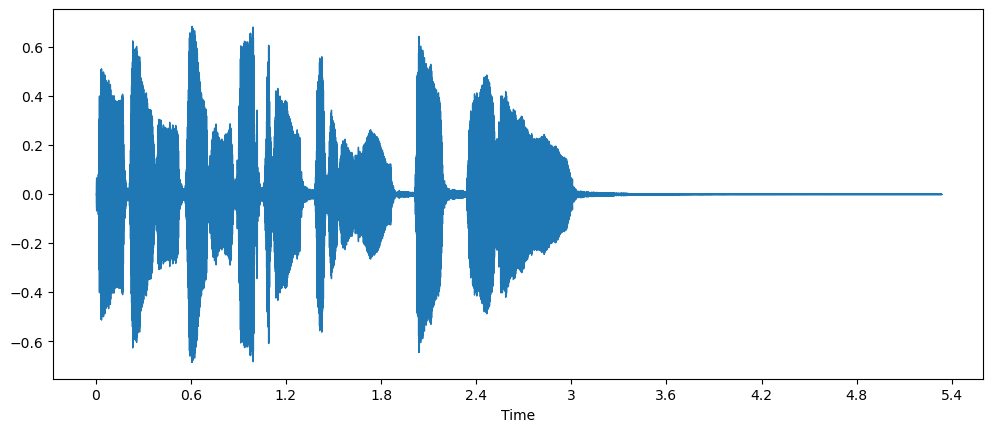

In [6]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

## Frequency Spectrum

In [4]:
import numpy as np

In [8]:
dft_input = array[:4096] # first 4096 samples. Length of first note

In [9]:
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

In [10]:
# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

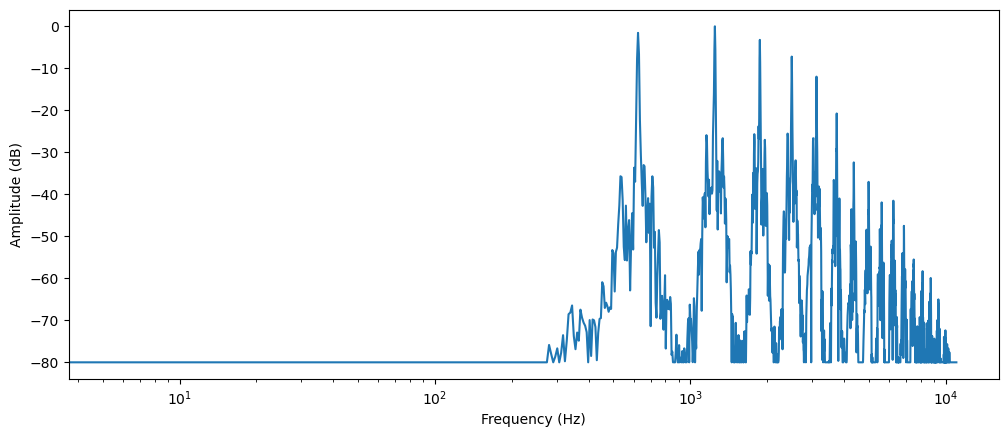

In [11]:
# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

## Spectrogram

In [12]:
D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

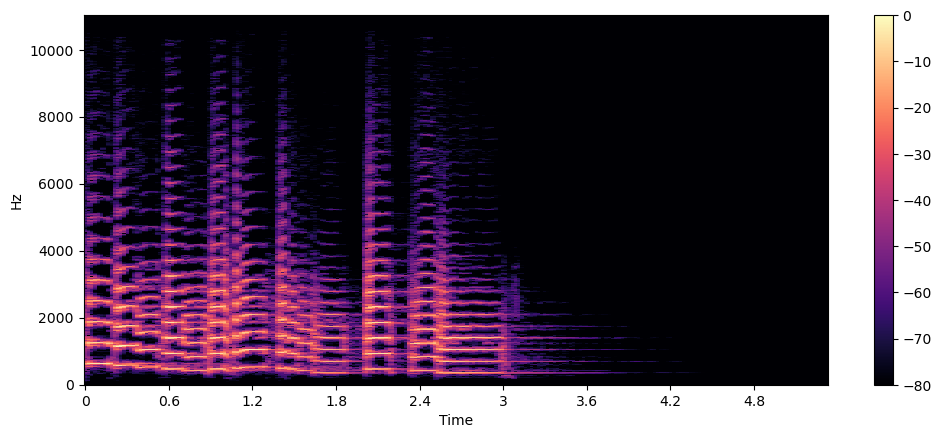

In [13]:
plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

## Mel Spectrogram

In [5]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)

In [6]:
S_dB = librosa.power_to_db(S, ref=np.max)

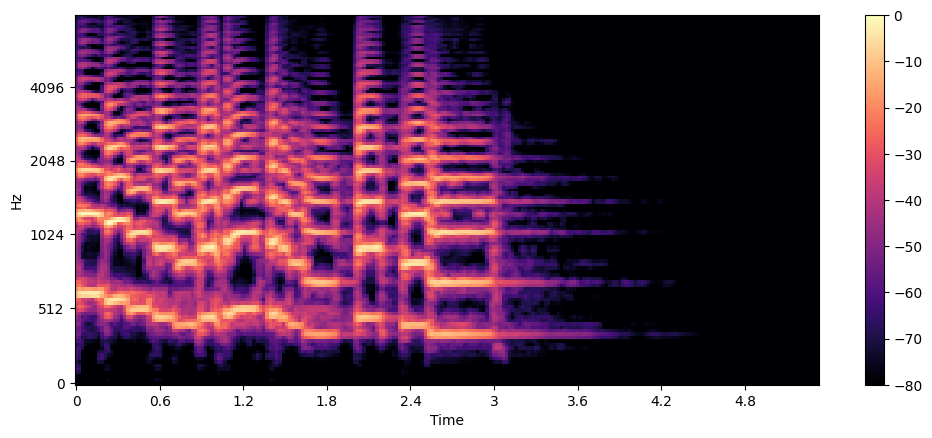

In [7]:
plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

# Exploring Audio Dataset

In [4]:
from datasets import load_dataset

In [5]:
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train", trust_remote_code=True)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [6]:
example = minds[0]
example

{'path': 'C:\\Users\\aarus\\.cache\\huggingface\\datasets\\downloads\\extracted\\1b6ad9ebd64bd96019ec7ea5df44d178d6740f3070dec74d78589850d0d4064a\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\aarus\\.cache\\huggingface\\datasets\\downloads\\extracted\\1b6ad9ebd64bd96019ec7ea5df44d178d6740f3070dec74d78589850d0d4064a\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [7]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [8]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [9]:
import gradio as gr

In [10]:
def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])

In [11]:
with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

C:\Users\aarus\anaconda3\envs\indicf5\Lib\site-packages\gradio\processing_utils.py:749: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


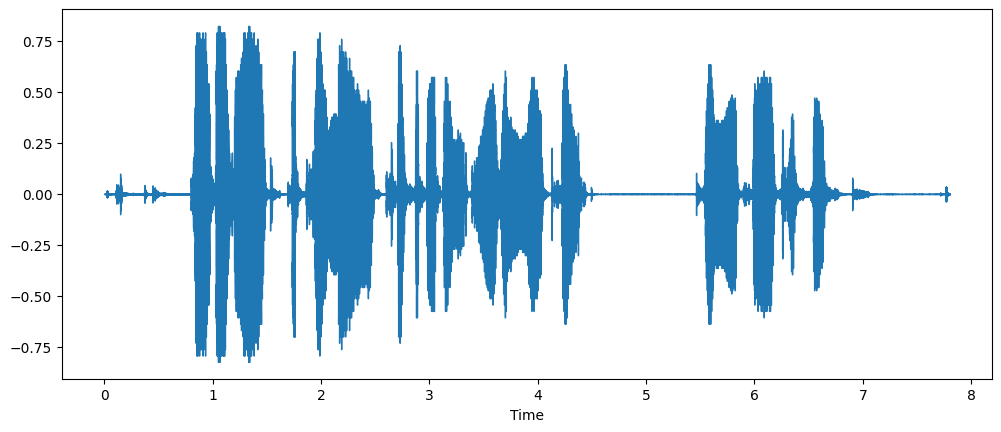

In [12]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

## Pre-processing

In [ ]:
from datasets import Audio
# Resampling data
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [15]:
minds[0]

{'path': 'C:\\Users\\aarus\\.cache\\huggingface\\datasets\\downloads\\extracted\\1b6ad9ebd64bd96019ec7ea5df44d178d6740f3070dec74d78589850d0d4064a\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\aarus\\.cache\\huggingface\\datasets\\downloads\\extracted\\1b6ad9ebd64bd96019ec7ea5df44d178d6740f3070dec74d78589850d0d4064a\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([2.36120541e-05, 1.92325111e-04, 2.19284673e-04, ...,
         9.40908678e-04, 1.16613181e-03, 7.20883720e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

> If an audio signal has been sampled at 8 kHz, so that it has 8000 sample readings per second, we know that the audio does not contain any frequencies over 4 kHz. This is guaranteed by the Nyquist sampling theorem. Because of this, we can be certain that in between the sampling points the original continuous signal always makes a smooth curve. Upsampling to a higher sampling rate is then a matter of calculating additional sample values that go in between the existing ones, by approximating this curve. Downsampling, however, requires that we first filter out any frequencies that would be higher than the new Nyquist limit, before estimating the new sample points. In other words, you can't downsample by a factor 2x by simply throwing away every other sample — this will create distortions in the signal called aliases. Doing resampling correctly is tricky and best left to well-tested libraries such as librosa or Datasets.

In [ ]:
MAX_DURATION_IN_SECONDS = 20.0
# Filtering the data
def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [17]:
# We don't have a duration column in the dataset. So we are creating that
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

In [18]:
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'duration'],
    num_rows: 654
})

In [19]:
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

Filter: 100%|███████████████████████████████████████████████████████████████| 654/654 [00:00<00:00, 7603.62 examples/s]


In [20]:
minds = minds.remove_columns(["duration"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

#### Feature Extraction using Whisper
>Raw Audio Data comes as array of sample values. However, pre-trained models req input features such as amplitude, sampling rate, frequence, etc. So we need to convert the array into features before using the models. 

> Whisper's Feature Extractor
    > 1. Pads/Truncate a batch of audio signals to input length of 30 s <br>
    (Since all elements in the batch are padded/truncated to a maximum length in the input space, there is no need for an attention mask. Whisper is trained to operate without an attention mask and infer directly from the speech signals where to ignore the inputs.)
    > 2. Convert Arrays to log-mel spectrogram


In [21]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

C:\Users\aarus\anaconda3\envs\indicf5\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aarus\.cache\huggingface\hub\models--openai--whisper-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [22]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [23]:
minds = minds.map(prepare_dataset)
minds

Map: 100%|████████████████████████████████████████████████████████████████████| 624/624 [01:51<00:00,  5.57 examples/s]


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

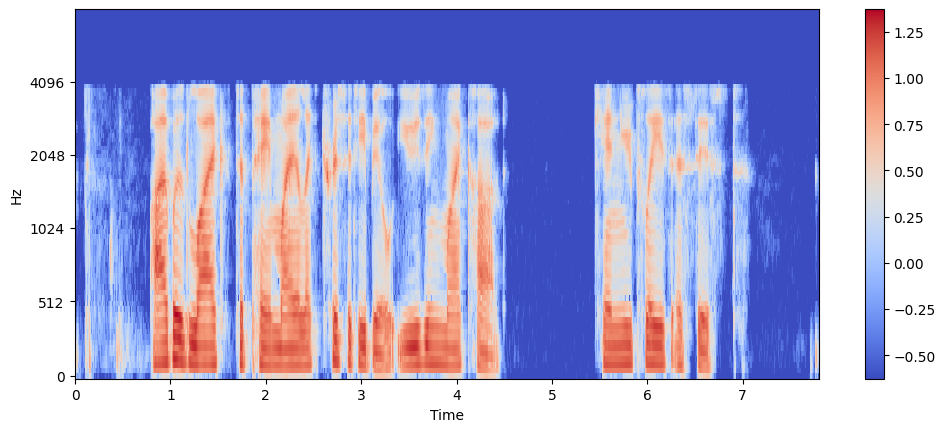

In [24]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [25]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

## Streaming Data

> Streaming allows us to load the data progressively as we iterate over the dataset. Rather than downloading the whole dataset at once, we load the dataset one example at a time. We iterate over the dataset, loading and preparing examples on the fly when they are needed. This way, we only ever load the examples that we’re using, and not the ones that we’re not! Once we’re done with an example sample, we continue iterating over the dataset and load the next one.

> Streaming mode has three primary advantages over downloading the entire dataset at once:
    > * Disk space: examples are loaded to memory one-by-one as we iterate over the dataset. Since the data is not downloaded locally, there are no disk space requirements, so you can use datasets of arbitrary size.
    > * Download and processing time: audio datasets are large and need a significant amount of time to download and process. With streaming, loading and processing is done on the fly, meaning you can start using the dataset as soon as the first example is ready.
    > * Easy experimentation: you can experiment on a handful of examples to check that your script works without having to download the entire dataset.


> There is one caveat to streaming mode. When downloading a full dataset without streaming, both the raw data and processed data are saved locally to disk. If we want to re-use this dataset, we can directly load the processed data from disk, skipping the download and processing steps. Consequently, we only have to perform the downloading and processing operations once, after which we can re-use the prepared data.


In [28]:
gigaspeech = load_dataset("PolyAI/minds14", "en-AU", streaming=True)

In [29]:
# Can't directly use indexing to access data. Need to iterate the data
next(iter(gigaspeech["train"]))

{'path': 'zip://en-AU~PAY_BILL/response_4.wav::zip://MInDS-14/audio.zip::https://huggingface.co/datasets/PolyAI/minds14/resolve/75900a7c6f93f014f25b50d16596a6da89add3a5/data/MInDS-14.zip',
 'audio': {'path': 'zip://en-AU~PAY_BILL/response_4.wav::zip://MInDS-14/audio.zip::https://huggingface.co/datasets/PolyAI/minds14/resolve/75900a7c6f93f014f25b50d16596a6da89add3a5/data/MInDS-14.zip',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [ ]:
# To preview more samples use take. It will give the first n elements
gigaspeech_head = gigaspeech["train"].take(2)
list(gigaspeech_head)